In [6]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
import sys
import os
import pickle
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
# parent_dir = os.path.abspath("../papers/attention_is_all_you_need")
# sys.path.append(parent_dir)
parent_dir = os.path.abspath("../utils/")
sys.path.append(parent_dir)
from pathlib import Path
from tqdm import tqdm

In [7]:
import yaml

YAML_PATH = Path("../")  / "papers" / "attention_is_all_you_need" / "config.yaml"
with open(YAML_PATH, "r") as file:
    config = yaml.safe_load(file)

## Get Training Data and Encode Training Data

In [9]:
from BPE.bpe import BPEEncoder, BPEDecoder


In [169]:
PATH = Path("../")  / "data" / "EnglishGerman" 
dataset = pd.read_csv(PATH / "wmt14_translate_de-en_validation.csv")

In [170]:
BPE_PATH = Path("../")  / "papers" / "attention_is_all_you_need" / "BPE" 
with open(BPE_PATH / "vocab_merges_2500.pkl", "rb") as f:
    vocab = pickle.load(f)

In [171]:
bpe_encoder = BPEEncoder(vocab=vocab)
english_encoded = bpe_encoder.encode(dataset.iloc[:, 1])
german_encoded = bpe_encoder.encode(dataset.iloc[:, 0])

KeyboardInterrupt: 

## Preparing the Data

In [16]:
max_vocab_size = max(vocab.values())
special_tokens = {max_vocab_size + 1 : "<SOS>",  max_vocab_size + 2 : "<EOS>", max_vocab_size + 3 : "<pad>"}
bpe_decoder = BPEDecoder(vocab=vocab, special_tokens=special_tokens)

In [17]:
class LanguageTranslationDataset(Dataset):
    def __init__(self, seq_length, src_encodings, tgt_encodings, sos_token, eos_token, pad_token):
        super().__init__()
        self.paired_encodings = LanguageTranslationDataset.augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token)
        self.seq_len = seq_length
        self.pad_token = pad_token

    @staticmethod
    def augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token):
        src_encodings = [[sos_token] + sublist + [eos_token] for sublist in src_encodings]
        tgt_encodings = [[sos_token] + sublist for sublist in tgt_encodings]
        output_encodings = [sublist + [eos_token] for sublist in tgt_encodings] 
        full_encoding = list(zip(src_encodings, tgt_encodings, output_encodings))
        full_encoding.sort(key=lambda x: len(x[0])) # sort sequence lengths
        return full_encoding


    def __getitem__(self, idx):
        src_seq, tgt_seq, output_seq = self.paired_encodings[idx]
        src_tensor = torch.tensor(src_seq, dtype=torch.long)
        tgt_tensor = torch.tensor(tgt_seq, dtype=torch.long)
        output_tensor = torch.tensor(output_seq, dtype=torch.long)

        src_tensor = F.pad(src_tensor, (0, self.seq_len - src_tensor.size(0)), value=self.pad_token)
        tgt_tensor = F.pad(tgt_tensor, (0, self.seq_len - tgt_tensor.size(0)), value=self.pad_token)
        output_tensor = F.pad(output_tensor, (0, self.seq_len - output_tensor.size(0)), value=self.pad_token)
        encoder_mask = (src_tensor != self.pad_token).int()

        subsequent_mask = torch.tril(torch.ones((self.seq_len, self.seq_len), dtype=torch.int))
        padding_mask = (tgt_tensor != self.pad_token).int()
        decoder_mask = subsequent_mask & padding_mask.unsqueeze(0)

        

        return {
            "src": src_tensor, # Seq_len
            "tgt": tgt_tensor, # seq_len
            "output": output_tensor, # seq_len
            "encoder_mask" : encoder_mask.unsqueeze(0).unsqueeze(0), # 1 x 1 x seq_len
            "decoder_mask" : decoder_mask.unsqueeze(0), # 1 x seq_len x seq_len
        }

    def __len__(self): 
        return len(self.paired_encodings)

In [18]:
full_data = LanguageTranslationDataset(seq_length=config['SEQ_LEN'], src_encodings=english_encoded, tgt_encodings=german_encoded, sos_token=max_vocab_size + 1, eos_token=max_vocab_size + 2,
                                        pad_token=max_vocab_size + 3)

train_data, test_data = random_split(full_data, [config['TRAIN_RATIO'], 1-config['TRAIN_RATIO']])

NameError: name 'english_encoded' is not defined

In [12]:
train_dataloader = DataLoader(train_data, batch_size=config['BATCH_SIZE'], shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=config['BATCH_SIZE'], shuffle=True, pin_memory=True)

## Model Creation

In [8]:
from TransformerComponents.Encoder import Encoder
from TransformerComponents.Decoder import Decoder
from TransformerComponents.PE import PositionalEmbedding
from TransformerComponents.Transformer import Transformer
from TransformerComponents.UtilsLayers import Projection

In [9]:
# vocab_size = len(vocab) + 256 + 3 # 3 special tokens
vocab_size = 8000

In [10]:
encoder_transformer = Encoder(config['N_ENCODERS'], config['N_HEADS'], config['D_MODEL'], config['D_MODEL'] // config['N_HEADS'], config['D_MODEL'] // config['N_HEADS'], config['FF_HIDDEN'], config['DROPOUT'])
decoder_transformer = Decoder(config['N_DECODERS'], config['N_HEADS'], config['D_MODEL'], config['D_MODEL'] // config['N_HEADS'], config['D_MODEL'] // config['N_HEADS'], config['FF_HIDDEN'], config['DROPOUT'])
src_embeddings = PositionalEmbedding(vocab_size, config['D_MODEL'], config['SEQ_LEN'], config['DROPOUT'])
tgt_embeddings = PositionalEmbedding(vocab_size, config['D_MODEL'], config['SEQ_LEN'], config['DROPOUT'])
projection = Projection(config['D_MODEL'], vocab_size)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(encoder_transformer, decoder_transformer, src_embeddings, tgt_embeddings, projection).to(device)

In [12]:
model.initialise()

## Model Training

In [18]:
def model_prediction(model, batch, max_len, device, sos_token, eos_token, pad_token):
    encoder_input = batch['src'].to(device) # B x seq_len
    encoder_mask = batch['encoder_mask'].to(device) # B  x 1 x 1 x seq_len
    encoder_output = model.encode(encoder_input, encoder_mask)
    B = encoder_input.size(0)
    decoder_input = torch.full((B, max_len), pad_token).to(device)
    decoder_input[: , 0] = sos_token
    finished = torch.zeros(B, dtype=torch.bool, device=device)

    for t in range(max_len - 1):
        subsequent_mask = torch.tril(torch.ones((max_len, max_len), dtype=torch.int)).expand(B, -1, -1) # shape: (B, max_len, max_len)
        other_mask =(decoder_input != pad_token).int().unsqueeze(1) # (B, 1, max_len)
        out = model.decode(decoder_input, encoder_output, encoder_mask, (subsequent_mask & other_mask).unsqueeze(1).to(device))
        prediction = model.proj(out) # Expected shape: (B, max_len, vocab_size)
        next_tokens = torch.argmax(prediction[:, t, :], dim=-1) # shape: (B, )
        next_tokens = torch.where(finished, pad_token, next_tokens)

        decoder_input[:, t + 1] = next_tokens
        finished |= (next_tokens == eos_token)

        if finished.all():
          break

    return decoder_input

In [19]:
writer = SummaryWriter('../papers/attention_is_all_you_need/Tensorboard/experiment_1')

In [22]:
class WarmupAdamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, warmup, optimiser):
        self.optimiser = optimiser
        self._step = 0
        self.warmup = warmup
        self.model_size = model_size
        self._rate = 0
    
    def state_dict(self):
        return {key: value for key, value in self.__dict__.items() if key != 'optimiser'}
    
    def load_state_dict(self, state_dict):
        self.__dict__.update(state_dict) 
        
    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimiser.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimiser.step()
        
    def rate(self, step = None):
        if step is None:
            step = self._step
        return (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5))) 

In [33]:
num_examples = 10
optimiser = WarmupAdamOpt(config['D_MODEL'], 500,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
# optimiser = torch.optim.Adam(model.parameters(), lr=config['LR'], eps=1e-9)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=max_vocab_size + 3, label_smoothing=0.1).to(device)

global_step_train = 0
global_step_test = 0
losses = []
test_losses = []
for epoch in range(config['NUM_EPOCHS']):
    model.train()
    batch_train = tqdm(train_dataloader, desc=f"Training epoch: {epoch:02d}")
    batch_loss = 0
    for data in batch_train:
        target_indices = data['output'].to(device) # B x seq_len

        encoder_input = data['src'].to(device) # B x seq_len
        tgt_input = data['tgt'].to(device) # B x seq_len
        encoder_mask = data['encoder_mask'].to(device) # B x 1 x 1 x seq_len
        decoder_mask = data['decoder_mask'].to(device) # B x 1 x seq_len x seq_len
        logits = model(encoder_input,  tgt_input, encoder_mask=encoder_mask, decoder_mask=decoder_mask)
        loss = loss_fn(logits.view(-1, vocab_size), target_indices.view(-1))
        batch_train.set_postfix({"loss": f"{loss.item(): 6.3f}"})
        batch_loss += loss.item()
        writer.add_scalar("train_loss", loss.item(), global_step_train)
        writer.flush()

        
        optimiser.optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        global_step_train += 1

    writer.add_scalar("batch_train_loss", batch_loss / len(batch_train), global_step_train // len(batch_train))
    writer.flush()


    model.eval()
    val_loss = 0
    batch_test = tqdm(test_dataloader, desc=f"Test epoch: {epoch:02d}")
    sample_taken = False
    for idx, data in enumerate(batch_test):
        with torch.no_grad():
            target_indices = data['output'].to(device)

            if not sample_taken:
                pred = model_prediction(model, data, config['SEQ_LEN'], device, max_vocab_size + 1, max_vocab_size + 2, max_vocab_size + 3)
                ints = torch.randint(low=0, high=pred.size(0), size=(num_examples,))
                pred = pred[ints, :]
                decoded = [decoded.replace("<pad>", "") for decoded in bpe_decoder.decode(pred.detach().cpu().tolist())]
                actual_decoded = [decoded.replace("<pad>", "") for decoded in bpe_decoder.decode(target_indices[ints, :].detach().cpu().tolist())]
                
                comparison_text = f"| Predicted | Actual |\n|-----------|--------|\n|"
                for j in range(len(decoded)):
                    comparison_text +=  f"{decoded[j]} | {actual_decoded[j]} | \n |"
                writer.add_text("Translation Comparison", comparison_text, global_step_test)
                writer.flush()
                global_step_test += 1
                sample_taken = True

            encoder_input = data['src'].to(device) # B x seq_len
            tgt_input = data['tgt'].to(device) # B x seq_len
            encoder_mask = data['encoder_mask'].to(device) # B x 1 x 1 x seq_len
            decoder_mask = data['decoder_mask'].to(device) # B x 1 x seq_len x seq_len
            logits = model(encoder_input,  tgt_input, encoder_mask=encoder_mask, decoder_mask=decoder_mask)
            loss = loss_fn(logits.view(-1, vocab_size), target_indices.view(-1))
            val_loss += loss.item()

    writer.add_scalar("val_loss", val_loss / len(batch_test), epoch)
    writer.flush()

    if epoch % 10 == 0:
      model_filename = f"../papers/attention_is_all_you_need/Models/model_{epoch}"
      torch.save({
          'epoch' : epoch,
          "model_state_dict" : model.state_dict(),
          "optimiser_state_dic" : optimiser.state_dict(),
          "global_step": global_step_train, 
          "global_step_test" : global_step_test
          }, model_filename)

Training epoch: 00:   5%|▌         | 2/38 [00:52<15:51, 26.43s/it, loss=7.820]


KeyboardInterrupt: 

## Analysing HPC Data

In [103]:
base_path = Path("../papers/attention_is_all_you_need/experiments")
exp_2 = "drop_warm"
exp_3 = "hindi_drop_warm_smoothen"
exp_1 = "no_drop_no_warm"

In [106]:
train_losses = {}
test_losses = {}
sentences = {}

for exp in [exp_3]:
    with open(base_path / f"{exp}_sentences.pkl", "rb") as f:
        sentences[exp] = pickle.load(f)

    with open(base_path / f"{exp}_train_loss.pkl", "rb") as f:
        train_losses[exp] = pickle.load(f)

    with open(base_path / f"{exp}_test_loss.pkl", "rb") as f:
        test_losses[exp] = pickle.load(f)

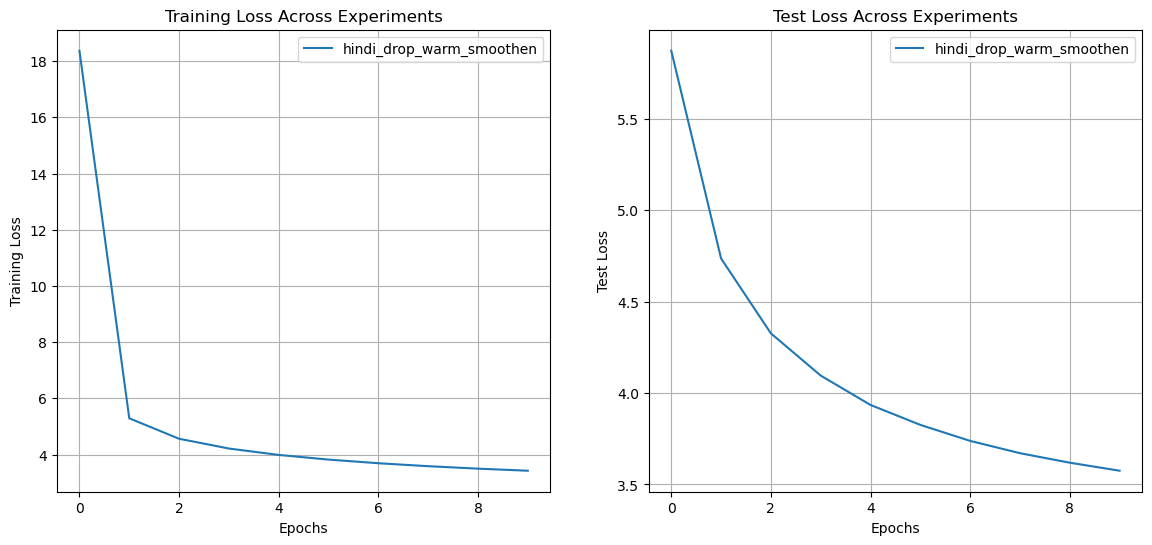

In [108]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot training losses
for exp_name, losses in train_losses.items():
    axes[0].plot(losses, label=exp_name)
axes[0].set_title("Training Loss Across Experiments")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Training Loss")
axes[0].legend()
# axes[0].set_yscale("log")
axes[0].grid(True)

# Plot test losses
for exp_name, losses in test_losses.items():
    axes[1].plot(losses, label=exp_name)
axes[1].set_title("Test Loss Across Experiments")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Test Loss")
axes[1].legend()
# axes[1].set_yscale("log")
axes[1].grid(True)

# Show the plots

In [137]:
def get_concatenated(files):
    train = [pd.read_csv(file + "_train_loss.txt", header=None) for file in files]
    test = [pd.read_csv(file + "_test_loss.txt", header=None) for file in files]
    return pd.concat(train, ignore_index=True), pd.concat(test, ignore_index=True)

In [138]:
train_total, test_total = get_concatenated(["../papers/attention_is_all_you_need/experiments/multi_hindi_drop_warm_smoothen_small_2", 
                  "../papers/attention_is_all_you_need/experiments/multi_hindi_drop_warm_smoothen_small_2_continued_0",
                  "../papers/attention_is_all_you_need/experiments/multi_hindi_drop_warm_smoothen_small_2_continued_2"])


In [195]:
train_total, test_total = get_concatenated(["../papers/attention_is_all_you_need/experiments/multi_hindi_s", 
                  "../papers/attention_is_all_you_need/experiments/multi_hindi_small_2"])

,0,1
0,(7.114044513258823,4.945246969232846)
1,(5.706829388197078,13.623965519296188)
2,(4.845957502098971,23.319698625609867)
3,(4.379551090196122,30.366214141250158)
4,(4.119131488023802,34.56980612817785)
...,...,...
135,(3.0211573767107587,52.993911942365266)
136,(3.0200702373371566,53.01657236625683)
137,(3.0190791701161586,53.02482056742473)
138,(3.017767006851906,53.056694835547766)


In [ ]:
spm.SentencePieceTrainer.train(input=['../data/en-hi/hindi_small_train.txt', '../data/en-hi/english_small_train.txt'], model_prefix="en-hi", model_type='bpe', vocab_size=8000, pad_id=3, bos_piece="<SOS>", eos_piece="<EOS>", unk_piece="<UNK>", pad_piece="<PAD>")

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ../data/en-hi/hindi_small_train.txt
  input: ../data/en-hi/english_small_train.txt
  input_format: 
  model_prefix: en-hi
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: 3
  unk_piece: <UNK>
  bos_piece: <SOS>
  eos_piece: <EOS>
  pad_piece: 

ded: freq=6648 size=1240 all=100406 active=7442 piece=▁गां
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6546 size=1260 all=101261 active=8297 piece=▁बद
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6465 size=1280 all=102399 active=9435 piece=der
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6319 size=1300 all=103752 active=10788 piece=▁दु
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=6307 min_freq=1116
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6198 size=1320 all=104762 active=6141 piece=ctions
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6122 size=1340 all=105784 active=7163 piece=ked
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=6006 size=1360 all=107029 active=8408 piece=▁15
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5909 size=1380 all=107814 active=9193 piece=▁बैठ
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=5792 size=1400 all=108871 active=10250 piece=▁आधार
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=5783 m

In [140]:
len(train_total)

385

TypeError: unhashable type: 'numpy.ndarray'

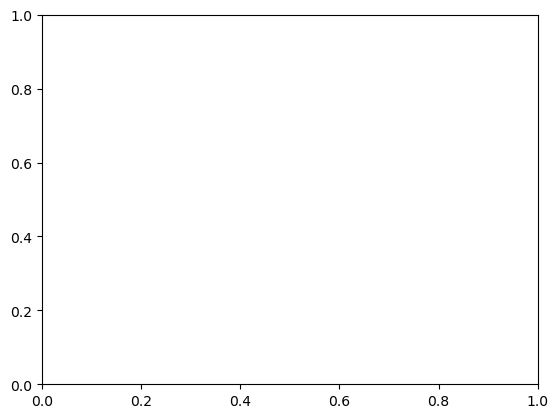

In [196]:
plt.plot(train_total)
plt.plot(test_total)
plt.legend(['train', 'test'])
# plt.yscale("log")

## Analysing hindi Translation Model

In [172]:
class LanguageTranslationDataset(Dataset):
    def __init__(self, seq_length, src_encodings, tgt_encodings, sos_token, eos_token, pad_token):
        super().__init__()
        self.paired_encodings = LanguageTranslationDataset.augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token)
        self.seq_len = seq_length
        self.pad_token = pad_token

    @staticmethod
    def augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token):
        src_encodings_app = [[sos_token] + sublist + [eos_token] for sublist in src_encodings]
        tgt_encodings_app = [[sos_token] + sublist for sublist in tgt_encodings]
        output_encodings = [sublist + [eos_token] for sublist in tgt_encodings] 
        full_encoding = list(zip(src_encodings_app, tgt_encodings_app, output_encodings))
        full_encoding.sort(key=lambda x: len(x[0])) # sort sequence lengths
        return full_encoding


    def __getitem__(self, idx):
            src_seq, tgt_seq, output_seq = self.paired_encodings[idx]
            
            # Convert to tensors
            src_tensor = torch.tensor(src_seq, dtype=torch.long)
            tgt_tensor = torch.tensor(tgt_seq, dtype=torch.long)
            output_tensor = torch.tensor(output_seq, dtype=torch.long)

            # **Ensure the sequence length does not exceed `seq_len`**
            if src_tensor.size(0) > self.seq_len:
                src_tensor = src_tensor[:self.seq_len]  # Crop excess tokens
            if tgt_tensor.size(0) > self.seq_len:
                tgt_tensor = tgt_tensor[:self.seq_len]  # Crop excess tokens
            if output_tensor.size(0) > self.seq_len:
                output_tensor = output_tensor[:self.seq_len]  # Crop excess tokens

            # **Pad sequences to `seq_len` if they are shorter**
            src_tensor = F.pad(src_tensor, (0, max(0, self.seq_len - src_tensor.size(0))), value=self.pad_token)
            tgt_tensor = F.pad(tgt_tensor, (0, max(0, self.seq_len - tgt_tensor.size(0))), value=self.pad_token)
            output_tensor = F.pad(output_tensor, (0, max(0, self.seq_len - output_tensor.size(0))), value=self.pad_token)
            encoder_mask = (src_tensor != self.pad_token).int()
            subsequent_mask = torch.tril(torch.ones((self.seq_len, self.seq_len), dtype=torch.int))
            padding_mask = (tgt_tensor != self.pad_token).int()
            decoder_mask = subsequent_mask & padding_mask.unsqueeze(0)



            return {
                "src": src_tensor, # Seq_len
                "tgt": tgt_tensor, # seq_len
                "output": output_tensor, # seq_len
                "encoder_mask" : encoder_mask.unsqueeze(0).unsqueeze(0), # 1 x 1 x seq_len
                "decoder_mask" : decoder_mask.unsqueeze(0), # 1 x seq_len x seq_len
            }
    def __len__(self): 
            return len(self.paired_encodings)

In [173]:
def model_prediction(model, batch, max_len, device, sos_token, eos_token, pad_token):
    encoder_input = batch['src'].to(device) # B x seq_len
    encoder_mask = batch['encoder_mask'].to(device) # B  x 1 x 1 x seq_len
    encoder_output = model.encode(encoder_input, encoder_mask)
    B = encoder_input.size(0)
    decoder_input = torch.full((B, max_len), pad_token).to(device)
    decoder_input[: , 0] = sos_token
    finished = torch.zeros(B, dtype=torch.bool, device=device)

    for t in range(max_len - 1):
        subsequent_mask = torch.tril(torch.ones((max_len, max_len), dtype=torch.int)).expand(B, -1, -1).to(device) # shape: (B, max_len, max_len)
        other_mask =(decoder_input != pad_token).int().unsqueeze(1) # (B, 1, max_len)
        decoder_mask = (subsequent_mask & other_mask).unsqueeze(1).to(device)
        out = model.decode(decoder_input, encoder_output, encoder_mask, decoder_mask)
        prediction = model.proj(out) # Expected shape: (B, max_len, vocab_size)
        next_tokens = torch.argmax(prediction[:, t, :], dim=-1) # shape: (B, )
        next_tokens = torch.where(finished, pad_token, next_tokens)

        decoder_input[:, t + 1] = next_tokens
        finished |= (next_tokens == eos_token)

        if finished.all():
          break

    return decoder_input

In [174]:
checkpoint = torch.load("../papers/attention_is_all_you_need/Models/multi_hindi_small/Model_100", map_location=torch.device('cpu'))

In [177]:
from collections import OrderedDict

checkpoint['model_state_dict'] = OrderedDict(
    (key[7:] if key.startswith("module.") else key, value)
    for key, value in checkpoint['model_state_dict'].items()
)


In [179]:
train_english = pd.read_table("../data/en-hi/train.en", header=None, skiprows=200_000, nrows=250000)
train_hindi = pd.read_table("../data/en-hi/train.hi", header=None, skiprows=200_000, nrows=250000)

In [180]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor(model_file='../papers/attention_is_all_you_need/BPE/en-hi.model')

In [181]:
import numpy as np
indices = np.random.randint(low=0, high=250_000, size=20)
inference_dataset = LanguageTranslationDataset(140,sp.encode_as_ids(train_english.iloc[indices, 0].to_list()), 
                                               sp.encode_as_ids(train_hindi.iloc[indices, 0].to_list()), sp.bos_id(), sp.eos_id(), sp.pad_id())
inference_data = DataLoader(inference_dataset, batch_size=len(indices))

In [182]:
batch = next(iter(inference_data))
preds = model_prediction(model, batch, 140, "cpu", sp.bos_id(), sp.eos_id(), sp.pad_id())

In [183]:
decoded = sp.decode(preds.detach().cpu().tolist())
actual_decoded = sp.decode(batch['tgt'][:, :].detach().cpu().tolist())
source_sentence = sp.decode(batch['src'][:, :].detach().cpu().tolist())

In [184]:
for i in range(len(decoded)):
    print(f"english sentence: {source_sentence[i]}")
    print(f"hindi sentence: {actual_decoded[i]}")
    print(f"model sentence: {decoded[i]}")
    print("-----------------------------------")

english sentence: Six of ...
hindi sentence: छठे दौ .
model sentence: छह में .
-----------------------------------
english sentence: Most wanted criminal arrested
hindi sentence: मोस्ट वांटेड बदमाश गिरफ्तार
model sentence: सबसे अधिक आरोपी गिरफ्तार
-----------------------------------
english sentence: But it was of no avail.
hindi sentence: मगर फायदा नहीं हुआ।
model sentence: लेकिन इसका कोई फायदा नहीं हुआ।
-----------------------------------
english sentence: He has benefitted from that.
hindi sentence: उसने लाभ कमाया है।
model sentence: इससे उन्हें फायदा हुआ है।
-----------------------------------
english sentence: Just one wrinkle.
hindi sentence: सिर्फएकशिकन .
model sentence: सिर्फ एक ही लकड़ी है।
-----------------------------------
english sentence: Failed to list objects:% s
hindi sentence: वस्तु सूचीबद्ध करने में विफलः% s
model sentence: वस्तु सूचीबद्ध करने में विफलः% s
-----------------------------------
english sentence: Rs 64 crore were released during 2000 - 01.
hindi sentence

In [ ]:
'Following his retirement from international cricket, his future in the T20 leagues was uncertain.', 'अंतरराष्ट्रीय क्रिकेट से संन्यास के बाद, टी 20 लीग में उनका भविष्य अनिश्चित था।', 'अंतरराष्ट्रीय क्रिकेट से संन्यास लेने के बाद, टी20 लीग में भविष्य का पता नहीं चल पाया है।'), 
("In Bihar, the Rashtriya Janata Dal won the Simri-Bakhtiarpur and Belhar seats, the AIMIM's  ⁇ amrul Hoda won in Kishanganj and the ruling Janata Dal-United in the Nathnagar constituency.", 'बिहार की किशनगंज में एआईएमआईएम, सिमरी बख्तिायारपुर और बेलहर में राष्ट्रीय जनता दल, नाथनगर में जनता दल (यूनाइटेड) और दरौंदा में निर्दलीय उम्मीदवार को जीत मिली।', 'बिहार में राष्ट्रीय जनता दल ने सिमर-बख्तियारपुर और बेल्हर सीट पर जीत हासिल की और एआईएमआईएमआईएम के क्वारुल होडा और नाथनगर सीट पर जनता दल यूनाइटेड में जीत हासिल की।'), 
("India has approved two vaccines Bharat Biotech's Covaxin and Serum Institute of India's Covishield for emergency use in the country.", 'देश में दो टीकों-कोवैक्सीन और सीरम इंस्टीट्यूट के कोविशील्ड को आपात उपयोग की मंजूरी मिली है।', 'भारत ने देश में आपातकालीन उपयोग के लिए भारत बायोटेक और सेरम इंस्टीट्यूट ऑफ इंडिया के कोविशील्डड को दो टीके को मंजूरी दी है।'), ('Police arrested two kidnappers in the case.', 'मामले में पुलिस ने दो फैक्ट्रियों पर छापा मारते हुए दो मिलावटखोरों को गिरफ्तार कर लिया।', 'पुलिस ने इस मामले में दो बदमाशों को गिरफ्तार कर लिया है।'), ('Or is it because you feel that the other person deliberately attempted to hurt you?', 'या क्या आपको लगता है कि किसी ने जानबूझकर आपको चोट पहुँचायी है?', 'या क्या आपने महसूस किया कि दूसरे व्यक्ति ने आपको चोट पहुंचाने का प्रयास किया?'), ('A note regarding transfer of indent.', 'मांग पत्र को हस्तांतरित करने वाला नोट (ज्ञापन)।', 'अनंतकालीन के बारे में कोई जानकारी।'), 
('On the India-US call for maritime freedom in the Indo-Pacific region Hua said, About the security navigation in the sea, we uphold the legal rights entitled in the international law and we also hope parties can do real things to ensure freedom of navigation.', 'भारत-प्रशांत क्षेत्र में समुद्री स्वतंत्रता के लिए भारत-अमेरिका के आह्वान के संदर्भ में हुआ ने कहा कि समुद्र में सुरक्षा नौवहन के बारे में हम अंतरराष्ट्रीय कानून में उल्लेखित कानूनी अधिकारों को कायम रखेंगे और हम यह उम्मीद भी करते हैं कि नौवहन स्वतंत्रता के लिए पक्ष वास्तविक काम करें।’’', 'भारत-अमेरिका के भारत-अमेरिका के लिए समुद्री स्वतंत्रता की अपील पर हुवा ने कहा, समुद्र में सुरक्षा नौवहन के बारे में हम अंतरराष्ट्रीय कानून में दायर कानूनी अधिकारों को बनाए रखते हैं और हम उम्मीद कर सकते हैं कि पक्ष ने भी सिंचाई की स्वतंत्रता सुनिश्चित करने के लिए वास्तविक चीजें कर सकते हैं।'), ('On receiving the information, the police reached the spot and shifted the body to the hospital for post-mortem.', 'सूचना मिलते ही पुलिस घटना स्थल पर पहुंच गई और शव को पोस्टमार्टम के लिए अस्पताल भेज दिया।', 'सूचना मिलते ही मौके पर पहुंची पुलिस ने शव को कब्जे में लेकर पोस्टमार्टम के लिए अस्पताल पहुंचाया।'), ('In response to a question about democratic socialism ultimately calling for an end to capitalism during a Firing Line interview on PBS, she answered: "Ultimately, we are marching towards progress on this issue.', 'लोकतांत्रिक समाजवाद के बारे में एक सवाल के जवाब में अंततः पीबीएस पर एक फायरिंग लाइन साक्षात्कार के दौरान पूंजीवाद को समाप्त करने का आह्वान किया, उसने जवाब दिया: "आखिरकार, हम इस मुद्दे पर प्रगति की ओर अग्रसर हैं।', 'पीबीएस पर फायरिंग लाइन साक्षात्कार के दौरान लोकतांत्रिक सामाजिकता के बारे में एक सवाल के जवाब में उन्होंने कहा, "पिछले ही हम इस मुद्दे पर प्रगति की ओर बढ़ रहे हैं।'), ('Organic manure covers manure made from cattle dung, excreta of other animals, rural and urban composts, other animal wastes, crop residues and green manures.', 'जैविक खाद में मवेशी के गोबर, जानवरों के अपशिष्ट, ग्रामीण और शहरी कम्पोस्ट, अन्य पशु अवशिष्ट, फसलों के अपशिष्ट और हरे खाद शामिल हैं।', 'जैविक मानवता के सहकर्मी, पशु धुँध, ग्रामीण और शहरी पदार्थों, अन्य जानवरों, फसलों और हरे हुए लोगों से भरी हुई।'), ('New Delhi: The Honourable Supreme Court has given its verdict on the Ayodhya issue.', 'नई दिल्ली: अयोध्या मामले को लेकर सुप्रीम कोर्ट से बड़ी खबर आई है.', 'नई दिल्ली: सुप्रीम कोर्ट ने अयोध्या मुद्दे पर अपना फैसला सुनाया है।'), ("India will be 5 trillion dollar economy by 2024: PM Modi at NITI Aayog's meet", 'BRICS: बिजनेस फोरम में PM मोदी बोले- 2024 तक 5 ट्रिलियन डॉलर होगी इकोनॉमी', 'नीति आयोग की बैठक में भारत 5 ट्रिलियन डॉलर की अर्थव्यवस्था होगी : पीएम मोदी'), 
('Thereafter, a ruckus ensued.', 'इसके बाद हडकम्प मच गया।', 'इसके बाद एक रुक गया।')

## Attention Visualisation

In [18]:
from attention_visualisation import get_attention


In [19]:
batch = next(iter(inference_data))
attention_dicts = get_attention(model, batch)

NameError: name 'inference_data' is not defined

In [193]:
# attention_dict --> (batch x n_heads x seq_len x seq_len)

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def process_and_visualise_attention(attentions, pixel_values, patch_size, threshold=0.6, raw_attn=False):    
    # Extract the CLS token attention (first token attending to all patches)    
    nh = attentions.shape[0]  # Number of attention heads
    attentions = attentions[:, 0, 1:].reshape(nh, -1)
    
    w_featmap = pixel_values.shape[-2] // patch_size
    h_featmap = pixel_values.shape[-1] // patch_size
    
    val, idx = torch.sort(attentions)  # Sort values per query
    val /= torch.sum(val, dim=1, keepdim=True)  # Normalize each col to sum to 1
    cumval = torch.cumsum(val, dim=1)  # Compute cumulative sum
    th_attn = cumval > (1 - threshold)  # Mask for top 'threshold' percentage
    idx2 = torch.argsort(idx)
    
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]

    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    th_attn = nn.functional.interpolate(
        th_attn.unsqueeze(0), scale_factor=patch_size, mode="bicubic"
    )[0].cpu().detach().numpy()

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(
        attentions.unsqueeze(0), scale_factor=patch_size, mode="bicubic"
    )[0].cpu().detach().numpy()

    image_np = pixel_values.permute(1, 2, 0).cpu().numpy()  # Shape: (H, W, C)
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize to [0,1]
    
    num_rows = 6 if raw_attn else 3  # Adjust number of rows based on raw_attn
    num_cols = 4  # Fixed number of columns
    figsize = (num_cols * 4, num_rows * 3)  # Adjust figure size dynamically

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)
    
    for head in range(12):  # Iterate over all heads
        row = head // num_cols  # Calculate row index
        col = head % num_cols   # Calculate column index
        
        ax = axes[row, col]
        ax.imshow(image_np)
        ax.imshow(th_attn[head], cmap="jet", alpha=0.4)
        ax.set_title(f"Head {head}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()


torch.Size([20, 4, 140, 140])

## Metrics Calculations

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from metrics import corpus_bleu, sentence_bleu

In [11]:
original_sentence_1 = "प्रचीन काल में एक राजा के राज्य में एकादशी के दिन सभी लोग व्रत रखते थे।"
model_sentence_1 = "प्राचीन काल में, सभी लोग एकादशी के दिन में, एकादशी के दिन में प्रचार करते थे।"
sentence_bleu([original_sentence_1], model_sentence_1, generate_more=True)

generated 1 more sentences


0.3967088290836577

In [12]:
original_sentence = 'भारत-प्रशांत क्षेत्र में समुद्री स्वतंत्रता के लिए भारत-अमेरिका के आह्वान के संदर्भ में हुआ ने कहा कि समुद्र में सुरक्षा नौवहन के बारे में हम अंतरराष्ट्रीय कानून में उल्लेखित कानूनी अधिकारों को कायम रखेंगे और हम यह उम्मीद भी करते हैं कि नौवहन स्वतंत्रता के लिए पक्ष वास्तविक काम करें।' 
original_sentence_mod = "उन्होंने कहा कि भारत-ऑस्ट्रेलिया के बीच समुद्री सुरक्षा के संबंध में भारत और अमेरिका के बीच सहमति बनी है।"
model_sentence = 'भारत-अमेरिका के भारत-अमेरिका के लिए समुद्री स्वतंत्रता की अपील पर हुवा ने कहा, समुद्र में सुरक्षा नौवहन के बारे में हम अंतरराष्ट्रीय कानून में दायर कानूनी अधिकारों को बनाए रखते हैं और हम उम्मीद कर सकते हैं कि पक्ष ने भी सिंचाई की स्वतंत्रता सुनिश्चित करने के लिए वास्तविक चीजें कर सकते हैं।'
a = sentence_bleu([original_sentence, original_sentence_mod], model_sentence, generate_more=False)
b = corpus_bleu([[original_sentence, original_sentence_mod]], [model_sentence])

generated 1 more sentences


In [13]:
t1 = corpus_bleu([[original_sentence, original_sentence_mod]], [model_sentence], raw_values=True)
t2 = corpus_bleu([[original_sentence_1]], [model_sentence_1], raw_values=True)

In [20]:
new_num = t1[0] + t2[0]
new_denom = t1[1] + t2[1]
new_ref = t1[3] + t2[3]
new_cand = t1[2] + t2[2]

In [22]:
from metrics import brevity_penality

In [25]:
import numpy as np
bp = brevity_penality(new_cand, new_ref)
pn = [new_num[i] / new_denom[i] if new_denom[i] > 0 else 0 for i in range(1, 5)]
log_sum = sum([w * np.log(p) if p > 0 else 0 for w,p in zip((0.25, 0.25, 0.25, 0.25), pn)])
bp * np.exp(log_sum)


0.264586891307893

In [13]:
import json
import glob
import os
combined_data = []

# Construct a file pattern to search for JSON files in the input folder
json_files = glob.glob(os.path.join("../data/en-hi/", '*.json'))

for file in json_files:
    try:
        with open(file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            combined_data.extend(data)
            # print(data)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from {file}: {e}")
    except Exception as e:
        print(f"An error occurred reading {file}: {e}")

# Write the combined data to the output file

with open("../data/en-hi/test.json", 'w') as f:
    json.dump(combined_data, f, indent=4)


In [16]:
corpus_bleu([[original_sentence, original_sentence_mod], [original_sentence_1]], [model_sentence, model_sentence_1])

0.264586891307893

In [ ]:
## pipeline

# read data from the relevant file and only enough rows as specified
# get the corresponding hindi ref sentences as well using the json 
# batch process them and generate model sentence for the whole batch
# pass the rel ref sentences and translated hindi sentences to corpus_bleu and get the raw values
# add the raw values to existing values and then return the summed total raw values write this to some file?
# get a master file thats whole purpose is to read a dir and update its master values with the file values, and then delete that file 
# print or write the file value to some implementation. 


## Future Thoughts
# Build that visualiser for attention heads
# build some abalation pipeline ? 
# be able to run experiments keeping the number of total parameters constant but changing number of heads etc or should I keep
# change the variable while keeping the rest of the config params constant

In [17]:
original_sentence =  'देश में दो टीकों-कोवैक्सीन और सीरम इंस्टीट्यूट के कोविशील्ड को आपात उपयोग की मंजूरी मिली है।'
model_sentence = 'भारत ने देश में आपातकालीन उपयोग के लिए भारत बायोटेक और सेरम इंस्टीट्यूट ऑफ इंडिया के कोविशील्डड को दो टीके को मंजूरी दी है।'
sentence_bleu([original_sentence], model_sentence, generate_more=True)

generated 1 more sentences


0.43759047241829613

## Testing Scores

In [14]:
from collections import OrderedDict
checkpoint = torch.load("../papers/attention_is_all_you_need/Models/hindi_model_small_full_5/Model_230", map_location=torch.device("cpu"))
checkpoint['model_state_dict'] = OrderedDict((k.replace("module.", ""), v) for k, v in checkpoint['model_state_dict'].items())
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [15]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor(model_file="../papers/attention_is_all_you_need/BPE/en-hi.model")
# model_prediction(model, None, config['SEQ_LEN'], device, sp.bos_id(), sp.eos_id(), sp.pad_id())

In [111]:
class LanguageTranslationDataset(Dataset):
    def __init__(self, seq_length, src_encodings, tgt_encodings, sos_token, eos_token, pad_token):
        super().__init__()
        self.paired_encodings = LanguageTranslationDataset.augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token)
        self.seq_len = seq_length
        self.pad_token = pad_token

    @staticmethod
    def augment_encodings(src_encodings, tgt_encodings, sos_token, eos_token):
        src_encodings_app = [[sos_token] + sublist + [eos_token] for sublist in src_encodings]
        tgt_encodings_app = [[sos_token] + sublist for sublist in tgt_encodings]
        output_encodings = [sublist + [eos_token] for sublist in tgt_encodings] 
        full_encoding = list(zip(src_encodings_app, tgt_encodings_app, output_encodings))
        # full_encoding.sort(key=lambda x: len(x[0])) # sort sequence lengths
        return full_encoding


    def __getitem__(self, idx):
            src_seq, tgt_seq, output_seq = self.paired_encodings[idx]
            # print(src_seq)
            
            # Convert to tensors
            src_tensor = torch.tensor(src_seq, dtype=torch.long)
            tgt_tensor = torch.tensor(tgt_seq, dtype=torch.long)
            output_tensor = torch.tensor(output_seq, dtype=torch.long)

            # **Ensure the sequence length does not exceed `seq_len`**
            if src_tensor.size(0) > self.seq_len:
                src_tensor = src_tensor[:self.seq_len]  # Crop excess tokens
            if tgt_tensor.size(0) > self.seq_len:
                tgt_tensor = tgt_tensor[:self.seq_len]  # Crop excess tokens
            if output_tensor.size(0) > self.seq_len:
                output_tensor = output_tensor[:self.seq_len]  # Crop excess tokens

            # **Pad sequences to `seq_len` if they are shorter**
            src_tensor = F.pad(src_tensor, (0, max(0, self.seq_len - src_tensor.size(0))), value=self.pad_token)
            tgt_tensor = F.pad(tgt_tensor, (0, max(0, self.seq_len - tgt_tensor.size(0))), value=self.pad_token)
            output_tensor = F.pad(output_tensor, (0, max(0, self.seq_len - output_tensor.size(0))), value=self.pad_token)
            encoder_mask = (src_tensor != self.pad_token).int()
            subsequent_mask = torch.tril(torch.ones((self.seq_len, self.seq_len), dtype=torch.int))
            padding_mask = (tgt_tensor != self.pad_token).int()
            decoder_mask = subsequent_mask & padding_mask.unsqueeze(0)



            return {
                "src": src_tensor, # Seq_len
                "tgt": tgt_tensor, # seq_len
                "output": output_tensor, # seq_len
                "encoder_mask" : encoder_mask.unsqueeze(0).unsqueeze(0), # 1 x 1 x seq_len
                "decoder_mask" : decoder_mask.unsqueeze(0), # 1 x seq_len x seq_len
            }
    def __len__(self): 
            return len(self.paired_encodings)
        

In [101]:
import itertools
def get_data(datapath, ref_datapath, skiprows, amount, sp):
    english_sentences = pd.read_table(Path(datapath) /  "english_small.txt",  header=None, skiprows=skiprows, nrows=amount)
    english_encoded = sp.encode_as_ids(english_sentences.iloc[:, 0].to_list())
    with open(ref_datapath / "test.json", 'r') as f:
        ref_sentences = json.load(f)
    ref_sentences = ref_sentences[ : amount]
    encoding_hindi = list(itertools.chain.from_iterable(ref_sentences))
    # assert len(english_encoded) == len(ref_sentences)
    hindi_encoded = sp.encode_as_ids(encoding_hindi)[:amount]
    return english_sentences, english_encoded, hindi_encoded, ref_sentences

In [102]:
def get_dataloaders(sp, english_encoded, tgt_encoded, amount):
    full_data = LanguageTranslationDataset(seq_length=config['SEQ_LEN'], src_encodings=english_encoded, tgt_encodings=tgt_encoded, sos_token=sp.bos_id(), eos_token=sp.eos_id(),
                                        pad_token=sp.pad_id())
    dataloader = DataLoader(full_data, batch_size=amount, pin_memory=True, shuffle=False)
    return full_data, dataloader

In [103]:
def model_prediction(model, batch, max_len, device, sos_token, eos_token, pad_token):
    underlying_model = model.module if hasattr(model, 'module') else model

    encoder_input = batch['src'].to(device)  # B x seq_len
    encoder_mask = batch['encoder_mask'].to(device)  # B x 1 x 1 x seq_len
    encoder_output = underlying_model.encode(encoder_input, encoder_mask)

    B = encoder_input.size(0)
    decoder_input = torch.full((B, max_len), pad_token).to(device)
    decoder_input[:, 0] = sos_token
    finished = torch.zeros(B, dtype=torch.bool, device=device)

    for t in range(max_len - 1):
        subsequent_mask = torch.tril(torch.ones((max_len, max_len), dtype=torch.int)).expand(B, -1, -1).to(device)
        other_mask = (decoder_input != pad_token).int().unsqueeze(1)
        decoder_mask = (subsequent_mask & other_mask).unsqueeze(1).to(device)
        out = underlying_model.decode(decoder_input, encoder_output, encoder_mask, decoder_mask)
        prediction = underlying_model.proj(out)  # shape: (B, max_len, vocab_size)
        next_tokens = torch.argmax(prediction[:, t, :], dim=-1)
        next_tokens = torch.where(finished, pad_token, next_tokens)
        decoder_input[:, t + 1] = next_tokens
        finished |= (next_tokens == eos_token)
        if finished.all():
            break

    return decoder_input

In [104]:
import json
english_sentences, english_encoded, hindi_encoded, ref_sentences = get_data(Path("../data/en-hi/"), Path("../data/en-hi/"), skiprows=1_000, amount=1024, sp=sp)

In [105]:
test, dataloader = get_dataloaders(sp, english_encoded, hindi_encoded, 32)

In [112]:
from collections import Counter
num_c = Counter({1: 0, 2: 0, 3: 0, 4:0})
denom_c = Counter({1: 0, 2: 0, 3: 0, 4:0})
ref_len = 0
cand_len = 0
for idx, batch in tqdm(enumerate(dataloader)):
    pred = model_prediction(model, batch, 140, "cpu", sp.bos_id(), sp.eos_id(), sp.pad_id())
    decoded = sp.decode(pred.detach().cpu().tolist())
    val1, val2, val3, val4 = corpus_bleu(ref_sentences[(idx) * 32: (idx + 1) * 32], decoded, raw_values=True)
    # break
    num_c += val1
    denom_c += val2
    cand_len += val3
    ref_len += val4

0it [00:00, ?it/s]

[1, 172, 1965, 54, 44, 3462, 7937, 258, 598, 794, 5071, 50, 14, 3521, 2823, 7959, 2]
[1, 1898, 114, 5978, 61, 544, 1092, 1375, 6837, 7899, 2]
[1, 97, 445, 442, 151, 1565, 661, 3278, 5414, 254, 26, 3050, 118, 7872, 235, 7870, 1962, 7942, 2682, 3098, 44, 14, 1009, 65, 2]
[1, 104, 5032, 302, 328, 7897, 254, 365, 228, 7, 1699, 44, 645, 2797, 5600, 7899, 2]
[1, 97, 954, 136, 7861, 210, 3023, 241, 1790, 7825, 37, 228, 5727, 1062, 7, 2797, 2042, 642, 1684, 7864, 342, 44, 733, 1325, 276, 3262, 86, 7975, 7978, 329, 304, 221, 16, 61, 733, 5503, 7935, 1237, 5414, 97, 4859, 116, 3452, 3533, 1079, 7846, 642, 61, 3539, 503, 4613, 40, 6467, 44, 14, 5975, 4381, 5778, 7899, 2]
[1, 104, 5786, 5947, 441, 7906, 7935, 7893, 538, 228, 383, 4611, 148, 14, 6014, 44, 14, 1665, 118, 338, 7862, 7893, 7959, 7986, 7986, 7890, 1387, 7864, 7899, 7865, 69, 7899, 8, 7986, 7974, 250, 7935, 7860, 1745, 69, 7935, 7884, 826, 169, 7942, 61, 7771, 239, 654, 7870, 311, 2611, 44, 2438, 148, 2207, 222, 7283, 44, 5309, 44, 975,

0it [00:03, ?it/s]


KeyboardInterrupt: 

In [5]:
from test_metrics_script import *

In [44]:
from metrics import brevity_penality
import numpy as np
bp = brevity_penality(cand_len, ref_len)
pn = [num_c[i] / denom_c[i] if denom_c[i] > 0 else 0 for i in range(1, 5)]
log_sum = sum([w * np.log(p) if p > 0 else 0 for w,p in zip((0.25, 0.25, 0.25, 0.25), pn)])
bp * np.exp(log_sum)

0.02846159391986035